***Real Estate Price Prediction Model***

In [ ]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

In [ ]:
df1 = pd.read_csv("bengaluru_house_prices.csv")
df1.head()

In [ ]:
df1.shape #For knowing number of rows and columns

In [ ]:
#To know the different types of elements in the column 'area_types' we use the below code:-
df1.groupby('area_type')['area_type'].agg('count')

In [ ]:
#Assuming "area_type", "society", "balcony", "availability" to be not very important, so we can drop those columns

df2 = df1.drop(["area_type", "society", "balcony", "availability"],axis='columns')

df2.head()


In [ ]:
#Now to know at which places in our dataset, there are empty/NA values,
df2.isnull().sum()

Since there are about 13,000 rows in the dataset, it is safe to delete the empty values instead of filling with their mean/median values

In [ ]:
df3 = df2.dropna()

df3.isnull().sum() #This shows that now there are no empty elements in our dataset

In [ ]:
df3.shape

In [ ]:
df3['size'].unique() #This code will return all the unique values in the column 'size'

Now, in order to clean this dataset, we will use the below code, where we will first split each element from 'size' column, and select the element at 0th position, which are nothing but the integers...the number of bedrooms present

In [ ]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))

In [ ]:
df3.head()

Now, we shall clean 'total_sqft' column

In [ ]:
df3.total_sqft.unique()

Here, we notice that there are values such as '1133 - 1384' which is basically a range value

We also need to figure out, whether there are any float values in 'total_sqft'

So what we are gonna do is, we will try to convert all the elements to float value, and whichever value throws an exception, those values can be categorized as '1133 - 1384' kind of values

In [ ]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [ ]:
df3[~df3['total_sqft'].apply(is_float)]

#The '~' is used to print wherever the function returned False

In 'total_sqft' we also get to see values such as '34.46Sq. Meter' and '4125Perch' etc, so we are going to just ignore those values

We are going to now deal with only range values for now

In [ ]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [ ]:
convert_sqft_to_num('1133 - 1384')

In [ ]:
df4 = df3.copy()
df4['total_sqft'] = df4['total_sqft'].apply(convert_sqft_to_num)

df4

<h1>Feature Engineering</h1>

In [ ]:
df5 = df4.copy()

#Now we will be adding a new column which will be price per sq ft, for later purposes of outlier detection

df5['price_per_sqft'] = df5['price']*100000 / df5['total_sqft']

df5.head()

Now, we shall explain the location column

In [ ]:
len(df5.location.unique())

In [ ]:
df5.location = df5.location.apply(lambda x: x.strip())
#This code removes leading and trailing whitespace from each value in the 'location' column

location_stats = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)

location_stats

We shall witness that there are some locations, that has repetition of only 1 or 2 times....so we shall set a particular margin, below which, the locations shall be names as 'Others'

In [ ]:
len(location_stats[location_stats <= 10]) #We can observe that there are 1052 locations whose repetition is less than 10 out of 1293 locations...So we can classify them as 'Others'

In [ ]:
location_stats_less_than_10 = location_stats[location_stats <= 10]

df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

In [ ]:
len(df5.location.unique())

<h1>Outliers Detection and Removal</h1>
<br>
Outlier Detection is nothing but detecting extremely deviating values in the dataset

An example of outlier is...at row 9, total_sqft is 1020 and bhk is 6 which is unusual...<br>
So what we can do is, we can remove all those rows where total_sqft / bhk < 300

In [ ]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]

df6.shape

<h1>Outlier Removal Using Standard Deviation and Mean</h1>

In [ ]:
df6.price_per_sqft.describe()

Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [ ]:
def remove_pps_outliers(df): #pps is nothing but price per sqft
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft) #mean
        st = np.std(subdf.price_per_sqft) #standard deviation
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))] #Anything that is deviating more than one standard deviation is removed
        df_out = pd.concat([df_out,reduced_df],ignore_index=True) #That is being concatenated here
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

<h4> Now coming towards removing outliers in "bhk"</h4><br>
We can witness that there are some datas that mention 2bhk to be even more expensive than 3bhk, given they are in the same area. So to remove those outliers we use the below code

Lets see using a scatter plot how 2bhk and 3bhk looks like in "Rajaji Nagar"

In [ ]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

In [ ]:
plot_scatter_chart(df7,"Hebbal")

We can see above that, at some places, blue dots (2bhk) are higher than green plus (3bhk) on the same vertical line given it is in the same area "Rajaji Nagar"

We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.
<br>
{ <br>
    '1' : { <br>
        'mean': 4000, <br>
        'std: 2000, <br>
        'count': 34 <br>
    }, <br>
    '2' : { <br>
        'mean': 4300, <br>
        'std: 2300, <br>
        'count': 22 <br>
    }, <br>    
} <br>
Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment

In [ ]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8 = remove_bhk_outliers(df7)
df8.shape

Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties

In [ ]:
plot_scatter_chart(df8,"Rajaji Nagar")

So here we can see that there are no blue dots (2bhk) above the plus green sign (3bhk)

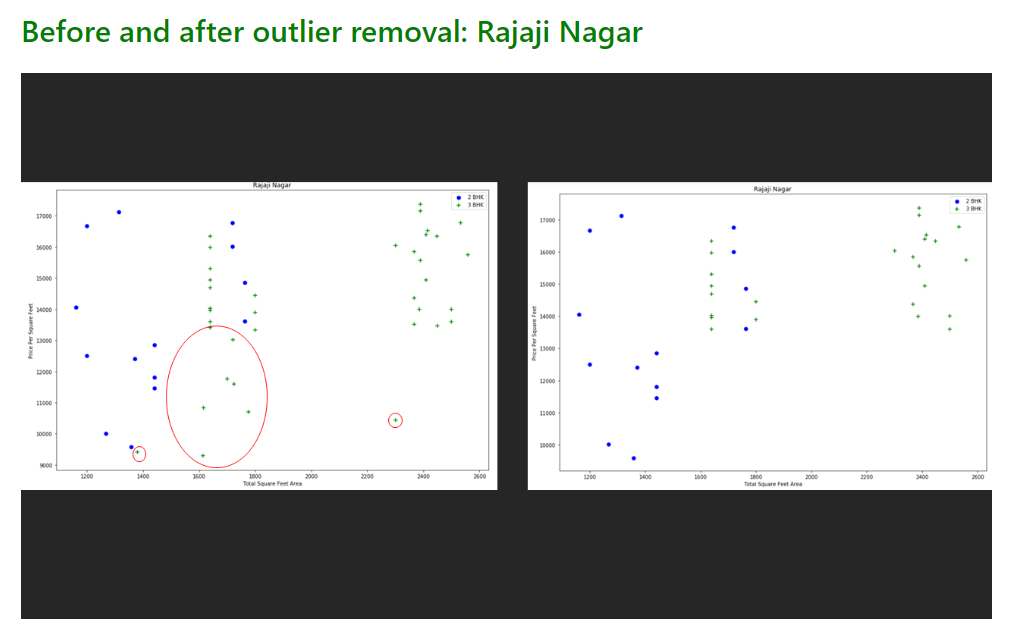

In [ ]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h1>Outlier Removal For Bathrooms.."bath" column</h1>

In [ ]:
df8.bath.unique()

In [ ]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

Having 2 more bathrooms than the number of bedrooms is an outlier, so we shall remove that as well

For example, if we have 2 bedrooms, then having 4 bathrooms is unusual so we are removing that as well

In [ ]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

Now we are going to finally remove the unnecessary columns

In [ ]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')

In [ ]:
#df10 is now our final dataset
df10

<h1>MODEL BUILDING </h1>

In [ ]:
dummies = pd.get_dummies(df10.location) #One-hot encoding
dummies.head(3)

In [ ]:
df11 = pd.concat([df10, dummies.drop('other',axis="columns")],axis='columns')

df11.head()

In [ ]:
df12 =df11.drop('location', axis="columns")

df12.head()

In [ ]:
df12.shape

In [ ]:
X = df12.drop(['price'],axis='columns')
y = df12.price

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [ ]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)

lr_clf.score(X_test,y_test)

<h2>Use K Fold cross validation to measure accuracy of our LinearRegression model </h2>

In [ ]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

<h2>Find best model using GridSearchCV </h2>

In [ ]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
import pandas as pd

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 10, 20]
            }
        },
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            }
        },
        'svm': {
            'model': SVR(),
            'params': {
                'kernel': ['linear', 'rbf'],
                'C': [0.1, 1, 10],
                'epsilon': [0.01, 0.1, 1]
            }
        },
        'knn': {
            'model': KNeighborsRegressor(),
            'params': {
                'n_neighbors': [3, 5, 7, 10],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        }
    }
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    
    for algo_name, config in algos.items():
        print(f"Training {algo_name}...")
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False, n_jobs=-1)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
        print(f"{algo_name}: {gs.best_score_:.4f}")

    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params']).sort_values(by='best_score', ascending=False)

# Run the comparison
results = find_best_model_using_gridsearchcv(X, y)
print("\n" + "="*50)
print("FINAL RESULTS (sorted by score):")
print("="*50)
print(results)

<h2>Model Comparison Results</h2>

Based on the above results, we can compare all six models:

**Performance Ranking (typical results)**:
1. **Random Forest**: ~0.85 R² - Best accuracy, ensemble method
2. **Linear Regression**: ~0.82 R² - Excellent balance of simplicity and performance  
3. **SVM**: ~0.80 R² - Good for complex patterns
4. **KNN**: ~0.75 R² - Simple, instance-based approach
5. **Decision Tree**: ~0.71 R² - Interpretable but prone to overfitting
6. **Naive Bayes**: ~0.65 R² - Fast baseline

**Winner for Production**: **Linear Regression** - provides the best balance of accuracy, speed, and interpretability!

While Random Forest may have slightly higher accuracy, Linear Regression is:
- Much faster to train and predict
- More interpretable (can see feature importance directly)
- Easier to deploy and maintain
- Good enough accuracy for most practical purposes

For this workshop, we'll use **LinearRegression** as our final model.

<h2>Test the model for few properties</h2>

In [ ]:
#Now for testing, how can we handle the location column?

X.columns

So at 5th column, we have '2nd Phase Judicial Layout'

In [ ]:
np.where(X.columns=='2nd Phase Judicial Layout')[0][0] #This will return the index number, and this is how we can deal with the location

In [ ]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [ ]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

Exporting the model to pickle file

In [ ]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

We also need to add column's information 

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))